## **EXP1 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP1 analysis and results. Files used were created in preprocessing/EXP1_pseudos notebook.*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file and can be run through paperpill using run_EXP1.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_adp_EXP3"
pseudo_name = "MCT_adp_EXP3"
noise_type = "nonoise"
files_path = "/../data/EXP3/"
cibersort_files = "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "realistic"
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
kerne_name = "env_ml"

In [3]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"

Import the previously processed datasets. 

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [4]:
#and as anndata object single nucleus 
adata_path = os.path.join(path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [5]:
#and single cell
adata_path = os.path.join(path, f"{res_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata

AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")
sc_prop.reindex()
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")
sn_prop.reindex()
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.232496
1,fat cell,24825,0.219657
2,macrophage,13625,0.120557
3,preadipocyte,26941,0.238380
4,endothelial cell,11480,0.101578
5,endothelial cell of lymphatic vessel,2339,0.020696
6,pericyte cell,1165,0.010308
7,T cell,3022,0.026739
8,dendritic cell,679,0.006008
9,mast cell,883,0.007813


In [7]:
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.053164
1,monocyte,636,0.034397
2,preadipocyte,13461,0.728015
3,endothelial cell of lymphatic vessel,157,0.008491
4,macrophage,1410,0.076257
5,T cell,807,0.043645
6,endothelial cell,542,0.029313
7,immature NK T cell,389,0.021038
8,pericyte cell,52,0.002812
9,mast cell,53,0.002866


In [8]:
# define the number of cells and the list of missing cell counts
num_cells_sn = len(sn_prop)
cell_order_sn = sn_prop["Cell_Types"].unique()

num_cells_sc = len(sc_prop)
cell_order_sc = sc_prop["Cell_Types"].unique()

Cells Missing from Real Proportions:

In [9]:
cells_names = np.setdiff1d(sn_prop["Cell_Types"].values, sc_prop["Cell_Types"].values)
cells_to_miss_idx = list()
for cell in cells_names:
    cells_to_miss_idx.append(sn_prop.loc[sn_prop['Cell_Types'] == cell].index[0])
cells_to_miss_idx

num_missing_cells = [0, len(cells_to_miss_idx)]

In [10]:
cells_to_miss = dict()
cells_to_miss[0] = []
cells_to_miss[num_missing_cells[1]] = cells_to_miss_idx

Importing CIBERSORTx results for genes:

In [11]:
# read in cibersort genes 
gene_ids_sn = sn_adata.var_names
gene_ids_sc = sc_adata.var_names

gene_ids = np.intersect1d(gene_ids_sc, gene_ids_sn)
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

2752

Cut anndatas to gene_ids from CIBERSORTx:

In [12]:
gene_mask = sn_adata.var_names.isin(gene_ids)
# Then, filter the AnnData object using the mask
sn_adata = sn_adata[:, gene_mask]

gene_mask = sc_adata.var_names.isin(gene_ids)
# Then, filter the AnnData object using the mask
sc_adata = sc_adata[:, gene_mask]

## Creating reference profiles from single cell and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [13]:
# Making cell type reference without scaling
cell_types_sc = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types_sc)
for cell_type in cell_types_sc:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

,dendritic cell,monocyte,preadipocyte,endothelial cell of lymphatic vessel,macrophage,T cell,endothelial cell,immature NK T cell,pericyte cell,mast cell
gene_ids,,,,,,,,,,
AATF,1447.0,1864.0,1205.0,2089.0,2091.0,1207.0,1757.0,1888.0,1840.0,2318.0
ABAT,671.0,585.0,415.0,290.0,624.0,571.0,221.0,344.0,387.0,405.0
ABCA10,706.0,608.0,10209.0,625.0,504.0,750.0,910.0,1083.0,1164.0,555.0
ABCA8,797.0,716.0,9492.0,1734.0,720.0,704.0,629.0,804.0,2385.0,727.0
ABCA9,1569.0,1116.0,20570.0,940.0,904.0,1251.0,1329.0,1415.0,3971.0,364.0
...,...,...,...,...,...,...,...,...,...,...
ZNRF3,299.0,276.0,603.0,198.0,295.0,95.0,1002.0,266.0,1734.0,0.0
ZSCAN31,29.0,31.0,51.0,0.0,82.0,0.0,143.0,54.0,370.0,0.0
ZSWIM5,824.0,518.0,685.0,1155.0,646.0,613.0,989.0,403.0,1191.0,551.0


In [14]:
# Making cell type reference without snaling
cell_types_sn = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw_sn = pd.DataFrame(index = gene_ids, columns = cell_types_sn)
for cell_type in cell_types_sn:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw_sn[cell_type] = sum_over_genes.values
ref_raw_sn

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
gene_ids,,,,,,,,,,,,
AATF,1816.0,3033.0,2805.0,1783.0,1912.0,1616.0,922.0,2264.0,2733.0,1491.0,3429.0,2636.0
ABAT,837.0,1470.0,2581.0,767.0,435.0,493.0,528.0,858.0,1765.0,680.0,2663.0,850.0
ABCA10,2118.0,14880.0,1024.0,56276.0,1522.0,1882.0,2398.0,1502.0,1697.0,1574.0,1544.0,1784.0
ABCA8,9759.0,15848.0,2454.0,30673.0,860.0,1230.0,8680.0,1153.0,1767.0,904.0,1180.0,804.0
ABCA9,1046.0,8483.0,15479.0,45235.0,880.0,1154.0,3722.0,1302.0,4893.0,1377.0,2138.0,1375.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,5864.0,6061.0,856.0,2211.0,1414.0,924.0,860.0,517.0,847.0,325.0,359.0,252.0
ZSCAN31,2985.0,944.0,264.0,867.0,1257.0,420.0,401.0,159.0,233.0,244.0,140.0,239.0
ZSWIM5,2664.0,2141.0,406.0,1703.0,1825.0,4206.0,1299.0,2280.0,619.0,572.0,421.0,1437.0


In [15]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types_sc)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types_sc)
ref_df

,dendritic cell,monocyte,preadipocyte,endothelial cell of lymphatic vessel,macrophage,T cell,endothelial cell,immature NK T cell,pericyte cell,mast cell
gene_ids,,,,,,,,,,
AATF,0.341572,0.440007,0.284446,0.493119,0.493591,0.284918,0.414749,0.445672,0.434341,0.547176
ABAT,0.158393,0.138092,0.097963,0.068456,0.147298,0.134787,0.052168,0.081203,0.091353,0.095602
ABCA10,0.166655,0.143521,1.000000,0.147534,0.118972,0.177041,0.214810,0.255648,0.274768,0.131011
ABCA8,0.188136,0.169015,1.000000,0.409319,0.169960,0.166183,0.148479,0.189788,0.562991,0.171612
ABCA9,0.370370,0.263437,1.000000,0.221892,0.213394,0.295305,0.313717,0.334018,0.937375,0.085924
...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.070580,0.065151,0.142341,0.046739,0.069636,0.022425,0.236527,0.062791,0.409319,0.000000
ZSCAN31,0.006846,0.007318,0.012039,0.000000,0.019357,0.000000,0.033756,0.012747,0.087340,0.000000
ZSWIM5,0.194509,0.122277,0.161698,0.272644,0.152492,0.144702,0.233458,0.095130,0.281142,0.130066


In [16]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_sn.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df_sn = scaler.transform(ref_raw_val)
ref_df_sn = pd.DataFrame(ref_df_sn, index = gene_ids, columns = cell_types_sn)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types_sn)
ref_df_sn

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
gene_ids,,,,,,,,,,,,
AATF,0.292548,0.488733,0.451957,0.286766,0.307918,0.260532,0.148645,0.364798,0.440615,0.240379,0.552824,0.424976
ABAT,0.134662,0.236624,0.415827,0.122807,0.069681,0.079482,0.085124,0.138049,0.284553,0.109630,0.429329,0.137037
ABCA10,0.341252,1.000000,0.164685,1.000000,0.245012,0.303416,0.386606,0.241908,0.273591,0.253760,0.248924,0.287617
ABCA8,1.000000,1.000000,0.395342,1.000000,0.138232,0.198301,1.000000,0.185624,0.284876,0.145743,0.190240,0.129621
ABCA9,0.168368,1.000000,1.000000,1.000000,0.141458,0.186048,0.600061,0.209654,0.788850,0.222000,0.344689,0.221678
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.945377,0.977144,0.137587,0.355835,0.227592,0.148967,0.138649,0.083055,0.136553,0.052397,0.057878,0.040627
ZSCAN31,0.481075,0.151782,0.042099,0.138945,0.202268,0.067712,0.064649,0.025320,0.037564,0.039338,0.022571,0.038532
ZSWIM5,0.429306,0.344855,0.065003,0.273855,0.293885,0.678092,0.209425,0.367378,0.099795,0.092218,0.067874,0.231673


Importing Bulks:

In [17]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.

#using number of cells in single nucleus, the one used ot create pseudobulks.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells_sn)+200) #1000
bulk_range["random"] = range((50*num_cells_sn)+200,(50*num_cells_sn)+400) #1200
bulk_range["equal"] = range((50*num_cells_sn)+400,(50*num_cells_sn)+600) #1400
bulk_range["all"] = range(0,(50*num_cells_sn)+600)

In [18]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1200

In [19]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_70740/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


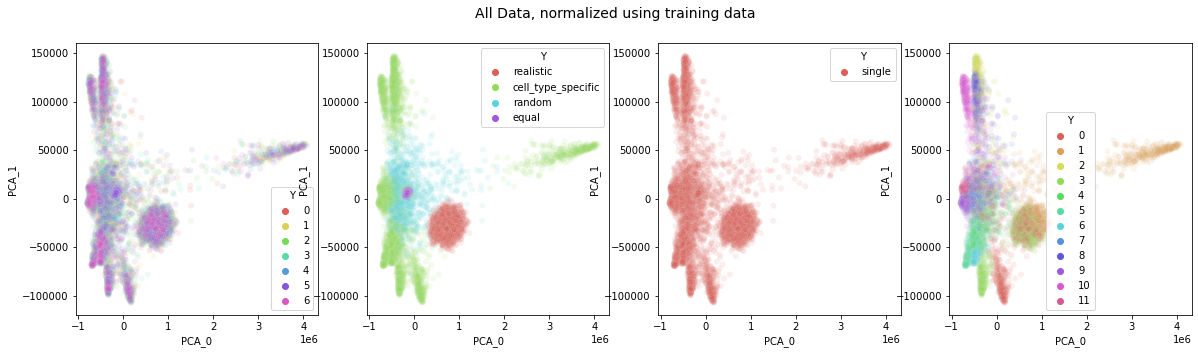

In [20]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [21]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulkprop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,55.0,130.0,10.0,2150.0,90.0,43.0,767.0,17.0,185.0,8.0,...,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,4.0,0.0
1,45.0,107.0,25.0,1857.0,94.0,58.0,783.0,19.0,232.0,6.0,...,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,2.0,0.0
2,54.0,117.0,22.0,2155.0,94.0,58.0,814.0,11.0,209.0,10.0,...,0.0,0.0,0.0,2.0,5.0,4.0,0.0,0.0,1.0,0.0
3,47.0,103.0,18.0,3238.0,98.0,37.0,797.0,11.0,295.0,8.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0
4,45.0,120.0,16.0,2547.0,107.0,48.0,788.0,12.0,200.0,7.0,...,0.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,52.0,101.0,11.0,2958.0,140.0,51.0,749.0,10.0,215.0,6.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0
1996,51.0,126.0,13.0,3043.0,117.0,48.0,737.0,19.0,229.0,5.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0
1997,69.0,120.0,11.0,2953.0,119.0,54.0,636.0,14.0,206.0,3.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,6.0,0.0
1998,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0


In [22]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,54.0,129.0,16.0,2119.0,122.0,37.0,696.0,15.0,156.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
929,56.0,128.0,16.0,2985.0,139.0,56.0,679.0,15.0,249.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1506,56.0,115.0,13.0,2966.0,94.0,53.0,747.0,12.0,260.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
237,44.0,100.0,18.0,3364.0,114.0,66.0,806.0,16.0,222.0,9.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0
1371,59.0,127.0,13.0,2712.0,93.0,46.0,699.0,10.0,220.0,11.0,...,0.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,57.0,120.0,16.0,2365.0,85.0,54.0,720.0,12.0,259.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
1132,69.0,128.0,21.0,2261.0,66.0,54.0,748.0,19.0,216.0,5.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0
1998,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0
1988,42.0,112.0,9.0,2961.0,118.0,65.0,702.0,15.0,209.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,0.516667,0.593407,0.428571,0.444610,0.465649,0.096774,0.343558,0.357143,0.081081,0.263158,...,0.000000,0.00,0.0,0.428571,0.0,0.0,0.0,0.00,0.222222,0.0
929,0.550000,0.582418,0.428571,1.000000,0.595420,0.403226,0.291411,0.357143,0.709459,0.263158,...,0.000000,0.00,0.0,0.142857,0.0,0.2,0.5,0.25,0.111111,0.0
1506,0.550000,0.439560,0.321429,1.000000,0.251908,0.354839,0.500000,0.250000,0.783784,0.368421,...,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.111111,0.0
237,0.350000,0.274725,0.500000,1.000000,0.404580,0.564516,0.680982,0.392857,0.527027,0.421053,...,0.000000,0.00,0.0,0.142857,0.4,0.2,0.0,0.25,0.333333,0.0
1371,0.600000,0.571429,0.321429,0.885502,0.244275,0.241935,0.352761,0.178571,0.513514,0.526316,...,0.000000,0.25,0.0,0.428571,0.2,0.6,0.0,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.566667,0.494505,0.428571,0.627509,0.183206,0.370968,0.417178,0.250000,0.777027,0.263158,...,0.000000,0.00,0.0,0.142857,0.0,0.0,0.0,0.25,0.222222,0.0
1132,0.766667,0.582418,0.607143,0.550186,0.038168,0.370968,0.503067,0.500000,0.486486,0.210526,...,0.000000,0.00,0.0,0.428571,0.0,0.2,0.5,0.25,0.111111,0.0
1998,0.483333,0.472527,0.285714,0.806691,0.351145,0.354839,0.518405,0.500000,0.250000,0.210526,...,0.333333,0.00,0.0,0.285714,0.2,0.2,0.0,0.25,0.444444,0.5
1988,0.316667,0.406593,0.178571,1.000000,0.435115,0.548387,0.361963,0.357143,0.439189,0.210526,...,0.000000,0.00,0.0,0.000000,0.0,0.2,0.0,0.00,0.111111,0.0


In [24]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
1059,0.492114,0.778195,0.0,0.0,0.0,0.248571,0.485876,0.485849,0.231312,0.554301,...,0.478022,0.527708,0.257206,0.414918,0.299748,0.528926,0.367292,0.539801,0.361371,0.0
929,0.160883,0.229323,0.0,0.0,0.0,0.500000,0.144068,0.238208,0.651622,0.362294,...,0.054945,0.274559,0.130820,0.347319,0.483627,0.297521,0.193029,0.283582,0.355140,0.0
1506,0.264984,0.278195,0.0,0.0,0.0,0.845714,0.112994,0.122642,0.622003,0.250217,...,0.082418,0.279597,0.148559,0.321678,0.617128,0.375443,0.734584,0.711443,0.236760,0.0
237,0.646688,0.593985,0.0,0.0,0.0,0.414286,0.429379,0.889151,0.753173,0.805387,...,0.461538,0.374055,0.075388,0.589744,0.841310,0.343566,0.018767,0.435323,0.526480,0.0
1371,0.293375,0.695489,0.0,0.0,0.0,0.371429,0.155367,0.497642,0.423131,0.948740,...,0.280220,0.258186,0.104213,0.829837,0.347607,0.279811,0.627346,0.189055,0.370717,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.331230,0.477444,0.0,0.0,0.0,0.405714,0.293785,0.393868,0.345557,0.466551,...,0.489011,0.374055,0.654102,0.601399,0.526448,0.513577,0.324397,0.850746,0.398754,0.0
1132,0.548896,0.323308,0.0,0.0,0.0,0.185714,0.341808,0.275943,0.293371,0.398784,...,0.505495,0.642317,0.266075,0.603730,0.279597,0.512397,0.426273,0.631841,0.358255,0.0
1998,0.432177,0.556391,0.0,0.0,0.0,0.340000,0.327684,0.334906,0.449929,0.502172,...,0.313187,0.370277,0.332594,0.480186,0.299748,0.552538,0.664879,0.492537,0.330218,0.0
1988,0.586751,0.481203,0.0,0.0,0.0,0.358571,0.200565,0.643868,0.472496,0.687228,...,0.439560,0.380353,0.272727,0.501166,0.342569,0.298701,0.324397,0.258706,0.464174,0.0


TSNEs of Pseuboulks and References:

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.30 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...
Iteration   50, KL divergence 1.2087, 50 iterations in 0.6161 sec
Iteration  100, KL divergence 1.1925, 50 iterations in 0.4832 sec
Iteration  150, KL divergence 1.1888, 50 iterations in 0.4926 sec
Iteration  200, KL divergence 1.1883, 50 iterations in 0.4722 sec
Iteration  250, KL divergence 1.1878, 50 iterations in 0.6306 sec
Iteration  300, KL divergence 1.1879, 50 iterations in 0.3145 sec
Iteration  350, KL divergence 1.1880, 50 iterations in 0.2404 sec
Iteration  400, KL divergence 1.1880, 50 iterations in 0.2240 sec
Iteration  450, KL divergence 1.1881, 50 iterations in 0.2317 sec
Iteration  500, KL divergence 1.1879, 50 iterations in 0.3031 sec
   --> Time elapsed: 4.02 seconds
===> Finding 15 nearest n

Perplexity value 60 is too high. Using perplexity 3.00 instead


Iteration   50, KL divergence 58.9413, 50 iterations in 0.0201 sec
Iteration  100, KL divergence 58.2231, 50 iterations in 0.0197 sec
Iteration  150, KL divergence 57.4873, 50 iterations in 0.0182 sec
Iteration  200, KL divergence 57.1333, 50 iterations in 0.0171 sec
Iteration  250, KL divergence 57.1123, 50 iterations in 0.0158 sec
   --> Time elapsed: 0.09 seconds
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=10.00 for 500 iterations...
Iteration   50, KL divergence 0.0179, 50 iterations in 0.2054 sec
Iteration  100, KL divergence 0.0199, 50 iterations in 0.2002 sec
Iteration  150, KL divergence 0.0171, 50 iterations in 0.2211 sec
Iteration  200, KL divergence 0.0194, 50 iterations in 0.2094 sec
Iteration  250, KL divergence 0.0189, 50 iterations in 0.2071 sec
Iteration  300, KL divergence 0.0212

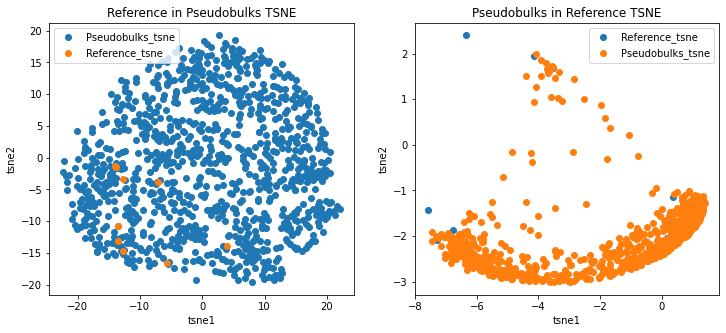

In [25]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

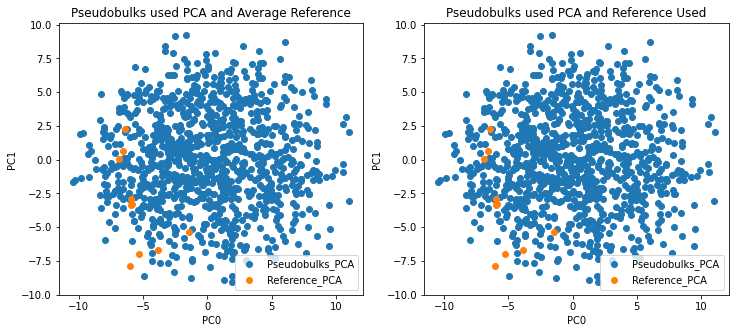

In [26]:
#PCA plots of reference dataframes with the normalized pseudobulks
plt.figure(figsize=(12, 5)) 
pca = PCA(n_components = 2)
pseudos_pca = pca.fit_transform(normalized_pseudo_df)
ref_pca = pca.transform(ref_df.T)
plt.subplot(1, 2, 1) 
plt.scatter(pseudos_pca[:,0], pseudos_pca[:,1], label = "Pseudobulks_PCA" )
plt.scatter(ref_pca[:,0], ref_pca[:,1], label = "Reference_PCA" )
plt.title("Pseudobulks used PCA and Average Reference")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend()
pca = PCA(n_components = 2)
pseudos_pca = pca.fit_transform(normalized_pseudo_df)
ref_pca = pca.transform(ref_df.T)
plt.subplot(1, 2, 2)
plt.scatter(pseudos_pca[:,0], pseudos_pca[:,1], label = "Pseudobulks_PCA" )
plt.scatter(ref_pca[:,0], ref_pca[:,1], label = "Reference_PCA" )
plt.title("Pseudobulks used PCA and Reference Used")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend()
plt.show()

In [27]:
prop_df

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
1059,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.02018,0.015646
929,0.23038,0.177024,0.096562,0.279433,0.110179,0.020464,0.00785,0.004998,0.004378,0.05881,0.003665,0.006257
1506,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.00256,0.02239,0.00615,0.004275,0.000941,0.006951
237,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.01198,0.004328
1371,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.252649,0.175555,0.10848,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
1132,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.00055
1998,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.0205,0.049767,0.001209,0.001988,0.007365,0.001881
1988,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.00092,0.008269,0.004246,0.008121


In [28]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df_sn
all_refs_raw[0] = ref_raw_sn
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df

#dropping cell types missing from references
for num in num_missing_cells[1:]:
    all_refs[num] = ref_df #.drop(ref_df.columns[cells_names], axis=1)
    all_refs_raw[num] = ref_raw #.drop(ref_raw.columns[cells_names], axis=1)
    all_prop_refs[num] = prop_df #.drop(prop_df.columns[cells_names], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num].drop(cells_names, axis=1) 
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [29]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0
Exp 2


Evalutating NNLS Performance:

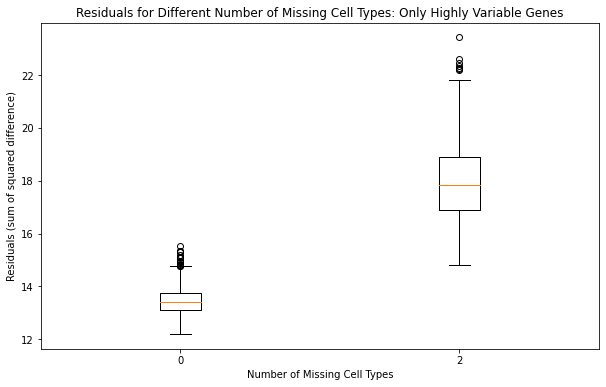

In [30]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

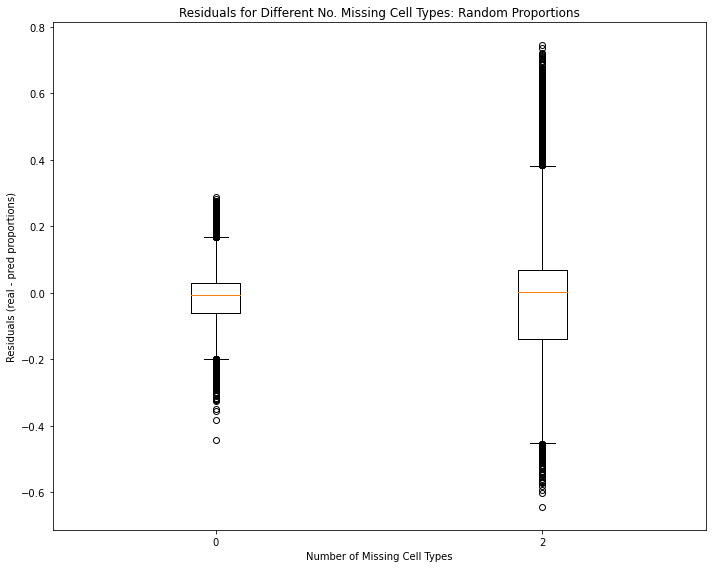

In [31]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

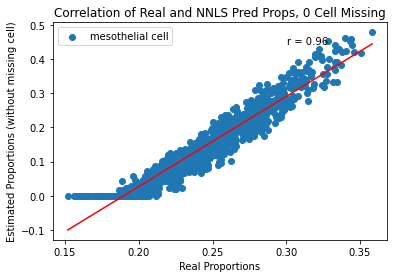

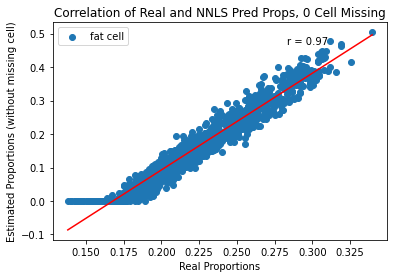

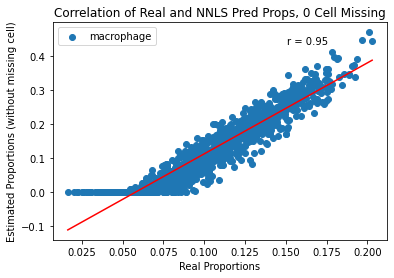

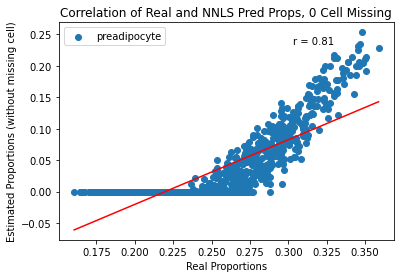

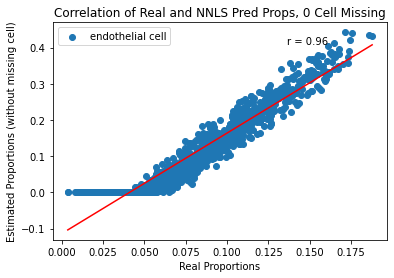

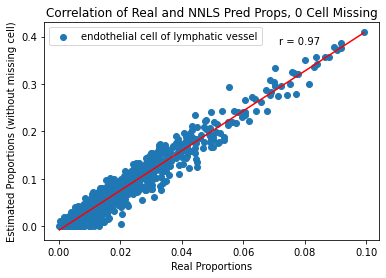

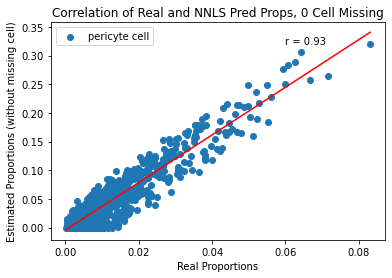

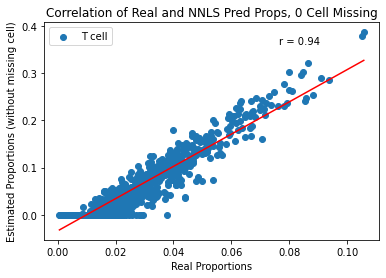

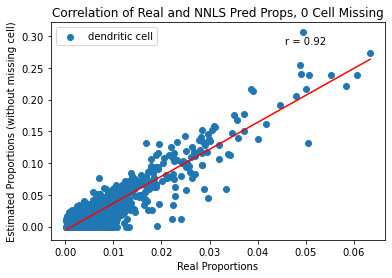

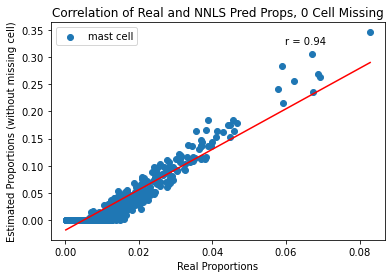

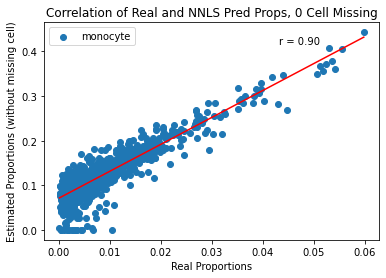

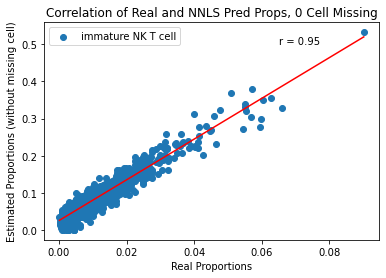

In [32]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


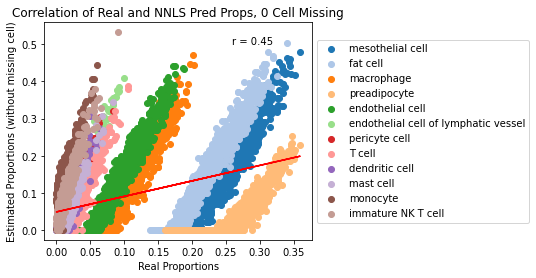

Real Proportions shape: (1000, 10)
Estimated Proportions shape: (1000, 10)


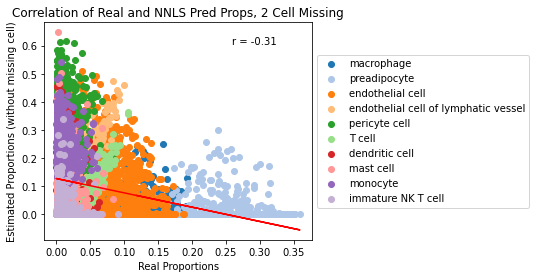

In [33]:
#Comparnig performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs_rebalanced[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    plt.show()


Recreate Matrices:

In [34]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,0.415534,0.252844,0.411309,0.552876,0.516219,0.159676,0.260517,0.259475,0.256336,0.403194,...,0.185303,0.348348,0.121948,0.358444,0.318163,0.449225,0.156695,0.237935,0.312686,1.0
1,0.311518,0.159511,0.317359,0.380621,0.344118,0.265319,0.170028,0.116965,0.521637,0.315839,...,0.124072,0.167879,0.087096,0.265293,0.480487,0.242491,0.137499,0.238658,0.228095,1.0
2,0.330011,0.129492,0.336992,0.474904,0.268448,0.531824,0.190817,0.071140,0.518546,0.285462,...,0.145816,0.277546,0.137266,0.292894,0.341795,0.407875,0.234367,0.315829,0.217341,1.0
3,0.425279,0.279605,0.370597,0.430868,0.629513,0.243452,0.271869,0.333307,0.410700,0.486129,...,0.176445,0.261261,0.031783,0.382285,0.361774,0.290909,0.092275,0.179649,0.304268,1.0
4,0.391201,0.295235,0.272837,0.539777,0.660773,0.136749,0.228760,0.313020,0.296655,0.620611,...,0.157077,0.139669,0.050663,0.460151,0.240238,0.279603,0.129930,0.173321,0.276170,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.346125,0.186293,0.354898,0.465120,0.423912,0.126187,0.209634,0.147752,0.177283,0.401815,...,0.146402,0.313243,0.385614,0.341880,0.269667,0.315239,0.134199,0.388576,0.259038,1.0
996,0.332193,0.183337,0.467265,0.745243,0.558721,0.131816,0.260560,0.154262,0.170668,0.353306,...,0.157907,0.357813,0.138168,0.334800,0.273565,0.441097,0.160316,0.294931,0.272854,1.0
997,0.381905,0.210014,0.388489,0.562996,0.473307,0.250922,0.247975,0.193932,0.280273,0.374327,...,0.168905,0.361198,0.214206,0.332723,0.284483,0.434672,0.166331,0.289563,0.274350,1.0
998,0.421409,0.264290,0.396987,0.457431,0.637984,0.211036,0.261774,0.295120,0.314213,0.488290,...,0.182303,0.312111,0.162860,0.380719,0.303938,0.305754,0.092756,0.219530,0.302713,1.0


## **Extracting Missing Cell Information:**

In [35]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))


In [36]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,0.076580,0.525352,-0.411309,-0.552876,-0.516219,0.088896,0.225358,0.226374,-0.025024,0.151107,...,0.292719,0.179360,0.135258,0.056474,-0.018415,0.079700,0.210597,0.301866,0.048684,-1.0
1,-0.150634,0.069812,-0.317359,-0.380621,-0.344118,0.234681,-0.025960,0.121242,0.129985,0.046455,...,-0.069127,0.106681,0.043724,0.082027,0.003141,0.055030,0.055531,0.044924,0.127046,-1.0
2,-0.065026,0.148704,-0.336992,-0.474904,-0.268448,0.313891,-0.077823,0.051501,0.103457,-0.035245,...,-0.063398,0.002051,0.011292,0.028785,0.275334,-0.032432,0.500218,0.395614,0.019419,-1.0
3,0.221408,0.314380,-0.370597,-0.430868,-0.629513,0.170833,0.157510,0.555844,0.342474,0.319257,...,0.285094,0.112794,0.043606,0.207459,0.479535,0.052657,-0.073508,0.255674,0.222212,-1.0
4,-0.097826,0.400254,-0.272837,-0.539777,-0.660773,0.234679,-0.073393,0.184622,0.126476,0.328129,...,0.123143,0.118518,0.053550,0.369686,0.107369,0.000208,0.497416,0.015734,0.094547,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.014894,0.291151,-0.354898,-0.465120,-0.423912,0.279527,0.084152,0.246116,0.168274,0.064736,...,0.342609,0.060812,0.268488,0.259518,0.256781,0.198338,0.190198,0.462170,0.139716,-1.0
996,0.216703,0.139971,-0.467265,-0.745243,-0.558721,0.053899,0.081247,0.121682,0.122703,0.045478,...,0.347588,0.284504,0.127908,0.268930,0.006032,0.071299,0.265957,0.336910,0.085401,-1.0
997,0.050272,0.346377,-0.388489,-0.562996,-0.473307,0.089078,0.079708,0.140974,0.169657,0.127845,...,0.144282,0.009079,0.118389,0.147463,0.015265,0.117866,0.498548,0.202974,0.055868,-1.0
998,0.165342,0.216913,-0.396987,-0.457431,-0.637984,0.147536,-0.061209,0.348748,0.158284,0.198938,...,0.257258,0.068242,0.109868,0.120446,0.038631,-0.007052,0.231641,0.039176,0.161461,-1.0


## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [37]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [38]:
# SVD on pseudobulk for QC
df = normalized_pseudo_df
Mat_pseudo = df.astype("float32")
U_pseudo, s_pseudo, V_pseudo = sp.linalg.svd(Mat_pseudo)
U_pseudo = pd.DataFrame(U_pseudo)
s_pseudo = pd.DataFrame(s_pseudo)
V_pseudo = pd.DataFrame(V_pseudo)

In [39]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

In [40]:
#SVD on reference for QC
U_all_ref = dict()
s_all_ref = dict()
V_all_ref = dict()
Matref_all_ref = dict()

for num in num_cells_missing:
    df = all_refs[num]
    Mat_ref  = df.astype("float32")
    U_ref , s_ref , V_ref  = sp.linalg.svd(Mat_ref )
    U_ref = pd.DataFrame(U_ref )
    s_ref  = pd.DataFrame(s_ref )
    V_ref  = pd.DataFrame(V_ref )

    U_all_ref[num] = U_ref 
    s_all_ref[num] = s_ref 
    V_all_ref[num] = V_ref 
    Matref_all_ref[num] = Mat_ref 

In [41]:
#SVD on recreated matrix for QC
U_all_rec = dict()
s_all_rec = dict()
V_all_rec = dict()
Matres_all_rec = dict()

for num in num_cells_missing:
    df = recreated_mat_all[num]
    Mat_rec = df.astype("float32")
    U_rec , s_rec , V_rec  = sp.linalg.svd(Mat_rec )
    U_rec  = pd.DataFrame(U_rec )
    s_rec  = pd.DataFrame(s_rec )
    V_rec  = pd.DataFrame(V_rec )

    U_all_rec[num] = U_rec 
    s_all_rec[num] = s_rec 
    V_all_rec[num] = V_rec 
    Matres_all_rec[num] = Mat_rec 

S-Value Eval for each SVD:

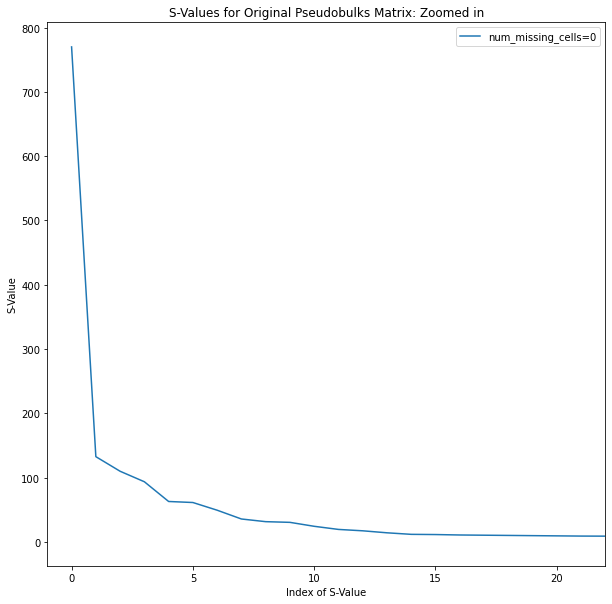

In [42]:
###SVD on Pseudobulk##
num =0
plt.figure(figsize = [10,10])
# Create a color map
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
dataframe = pd.DataFrame(s_pseudo)
x = dataframe.index
y = dataframe.values.flatten()
color = color_map(num_missing_cells.index(num))
label = f"num_missing_cells={num}"
plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Original Pseudobulks Matrix: Zoomed in')
plt.xlim([-1,num_celltypes + 10])
# Add a legend
plt.legend()
# Display the plot
plt.show()

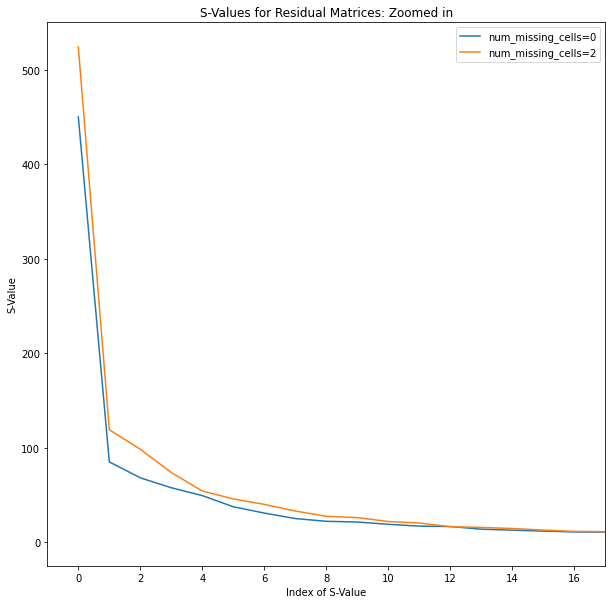

In [43]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

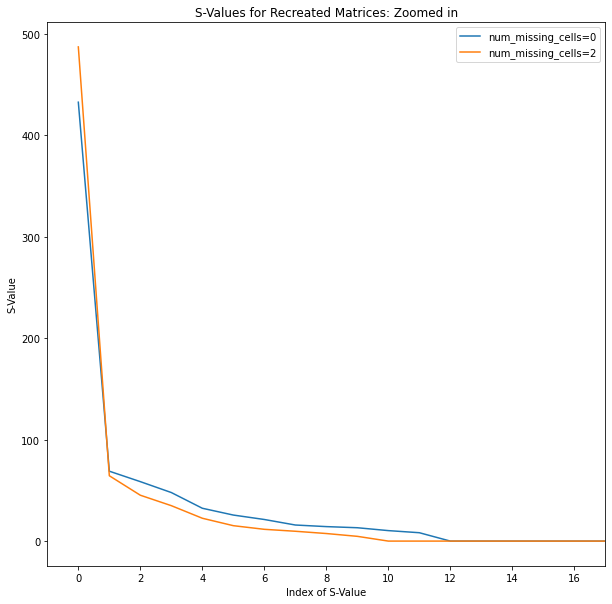

In [44]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_rec[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Recreated Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

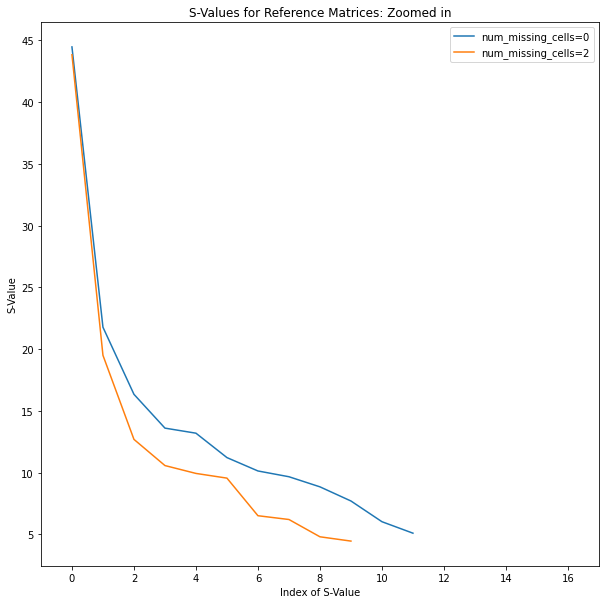

In [45]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_ref[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Reference Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [46]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

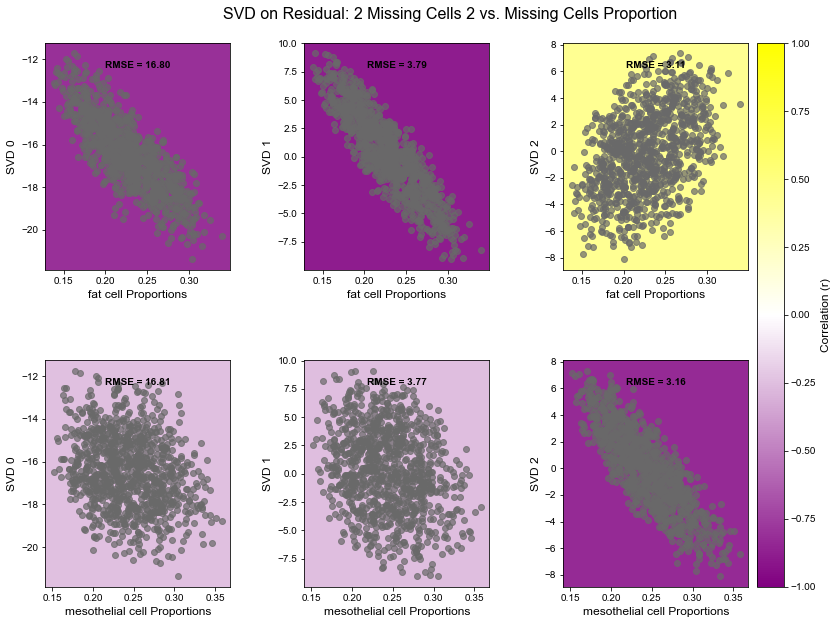

In [47]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

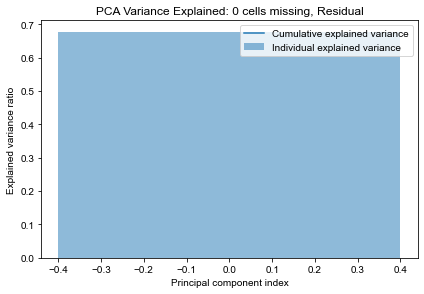

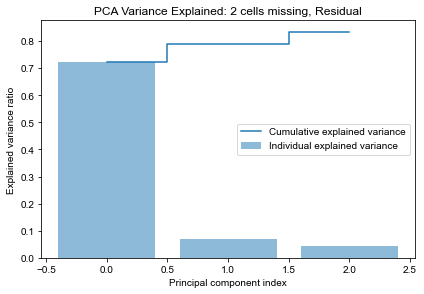

In [48]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

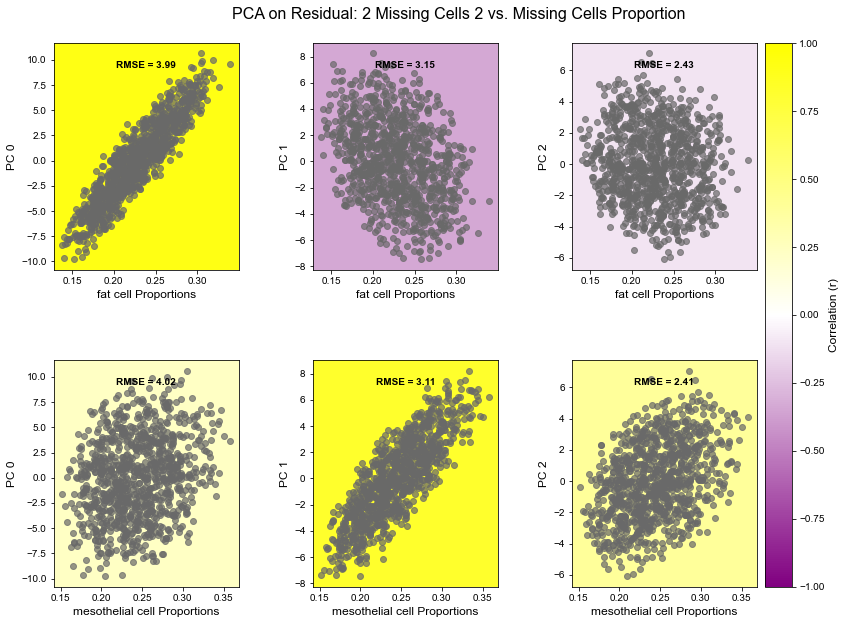

In [49]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [50]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

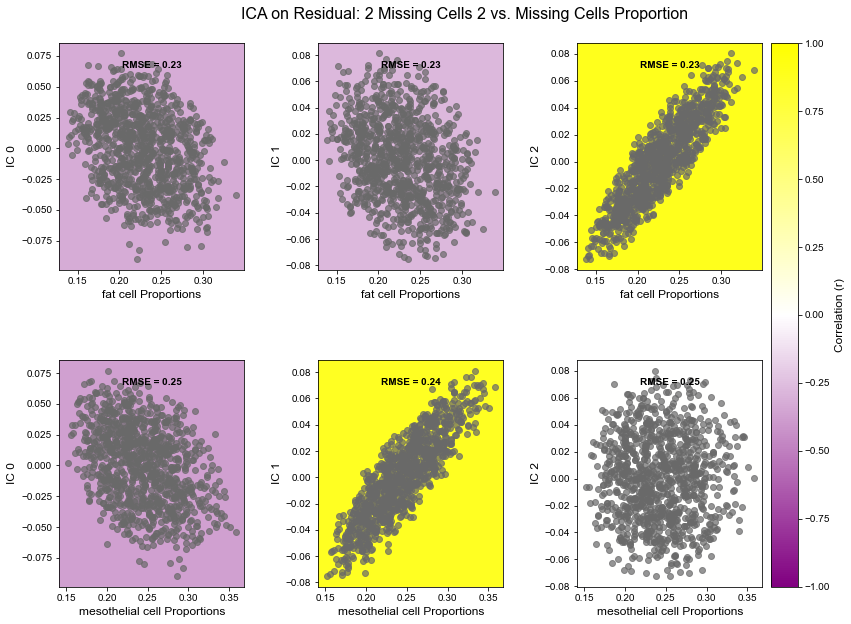

In [51]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

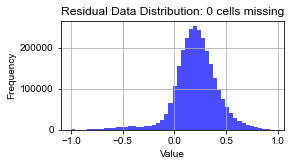

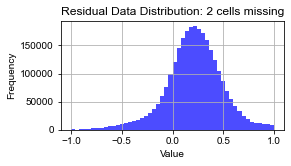

In [52]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000992165177


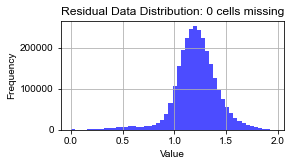

1.0000000000000004


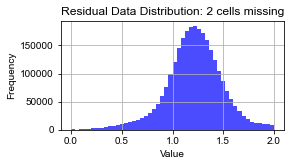

In [53]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Analyzing NMF Results:

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


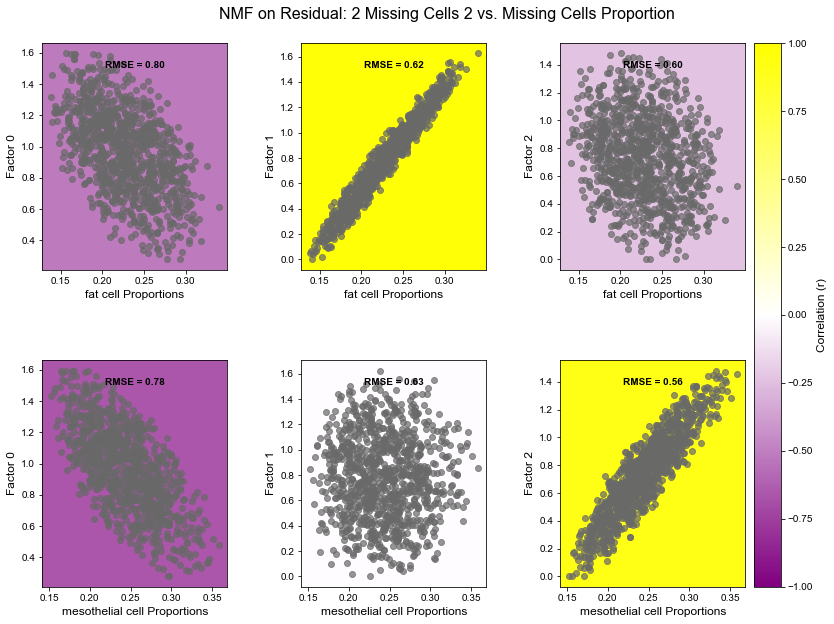

In [54]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter=10000, init = 'nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 